In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
def policy_func(beta,m):
    '''
    beta is a constant parameter
    m is an array of how many action variables do we have.
    
    return p which is an array of the probability for each action variable
    
    '''
    total_sum=np.sum( np.exp(beta*m_i) for m_i in m )
    p=[np.exp(beta*m_i)/total_sum for m_i in m]
    return p


In [4]:
# choose action based on the probability of the policies, so 
# probabilistically choose either L,R or C
def choose_action(policies):
    '''
    This function chooses which action given their higher probabilities in the policy function
    '''
    # choose action based on the probability of the policies stochastically
    # choose either L,R or C
    if len(policies) == 3:
        action = np.random.choice(['L','R','C'],p=policies)
    elif len(policies) == 2:
        action = np.random.choice(['L','R'],p=policies)
    return action
    


In [5]:

def reward_func(u,action_choice):
    '''
    u is the state takes values as 1,2,3
    m is the action which takes values of 0,1,2 for left, right,center if u ==1
    But if u is either 2,3 it'll take values of -1 or 1 for left and right
    '''
    
    if u==1:
        if action_choice=='L':
            return 1
        elif action_choice=='C':
            return -1
        elif action_choice=='R':
            return 2
    elif u==2:
        if action_choice=='L':
            return 8
        elif action_choice=='R':
            return -8
    elif u==3:
        if action_choice=='L':
            return 0
        elif action_choice=='R':
            return 4
    
    else:

        ValueError(f'Invalid action or state with values {action_choice} and {u}!')

In [6]:
            
def second_step_state_func():
    '''
    This function probabilistically returns either state 2 or 3 with 0.5 probability
    '''
    states=[2,3]
    u=random.choice(states)
    return u



In [7]:
def delta_error_func(v_u,v_u_prime,reward):
    
    return reward+v_u_prime-v_u


In [8]:

def update_action_variable(action_choice,m,alpha_A,alpha,delta):
    '''
    action_choice is the action choice, 0 is the left and 1 is the right and 2 Center
    if there are three values. if they are two, then 0 is left and 1 is right.
    
    alpha is the learning rate, 
    
    delta is the error array for all action variables
    This is to only update its corresponding m 
    '''
    
    if action_choice=='L':
        update_index=0
    elif action_choice=='R':
        update_index=1
    elif action_choice=='C':
        update_index=2
    
    for i in range(len(m)):
        
        if i==update_index:            
            m[i]=m[i]+alpha_A*delta
        else:
            m[i]=m[i]
    return m


In [9]:
def update_values(alpha,v,delta,state):
    
    v[state]=v[state]+0.2*delta
    return v

In [10]:
def actor_critic(n_trials,alpha,beta,alpha_A):
    
    
    num_states=3
    m_1=np.zeros((3,n_trials))
    m_2=np.zeros((2,n_trials))
    m_3=np.zeros((2,n_trials))
    v=np.zeros((num_states+1,n_trials)) # we ignore the first dimension of index 0
    
    policy_hist_1=np.zeros((3,n_trials))
    policy_hist_2=np.zeros((2,n_trials))    
    policy_hist_3=np.zeros((2,n_trials))
    
    delta_hist=np.zeros((num_states+1,n_trials))
    state=1
    for trial in range(n_trials-1):
        
          
        policies_m1=policy_func(beta,m_1[:,trial])
        policy_hist_1[:,trial]=policies_m1
        
        policies_m2=policy_func(beta,m_2[:,trial])
        policy_hist_2[:,trial]=policies_m2
        
        policies_m3=policy_func(beta,m_3[:,trial])
        policy_hist_3[:,trial]=policies_m3
        
        
        policies=policies_m1
        
        action_choice=choose_action(policies)
        reward=reward_func(state,action_choice)
        
    
        if action_choice=='L' or action_choice=='R' and state==1:
            
            # This means the agent won't take a second step
            delta=delta_error_func(v[state,trial],0,reward)
            v[:,trial]=update_values(alpha,v[:,trial],delta,state)
            m_1[:,trial]=update_action_variable(action_choice,m_1[:,trial],alpha_A,alpha,delta)
            
        elif action_choice=='C':
            u_prime=second_step_state_func()
            # This is the temporal difference for the next state
            delta=delta_error_func(v[state,trial],v[u_prime,trial],reward) # here state+1 is zero because of the initialization :) but I'll hard code it for now that w_u_prime is always 0 
            v[:,trial]=update_values(alpha,v[:,trial],delta,state)
            m_1[:,trial]=update_action_variable(action_choice,m_1[:,trial],alpha_A,alpha,delta)
            delta_hist[state,trial]=delta
            
            if u_prime==2:
                policies=policies_m2
                
                
                action_choice=choose_action(policies)
                
                reward=reward_func(u_prime,action_choice)
                
                delta=delta_error_func(v[u_prime,trial],0,reward)
                
                m_2[:,trial]=update_action_variable(action_choice,m_2[:,trial],alpha_A,alpha,delta)
                delta_hist[u_prime,trial]=delta
                v[:,trial]=update_values(alpha,v[:,trial],delta,u_prime)
                
                state=1
            elif u_prime==3:
                
                
                
                policies=policies_m3
                action_choice=choose_action(policies)
                
                reward=reward_func(u_prime,action_choice)
                
                delta=delta_error_func(v[u_prime,trial],0,reward)
                
                m_3[:,trial]=update_action_variable(action_choice,m_3[:,trial],alpha_A,alpha,delta)
                
                delta_hist[u_prime,trial]=delta
                v[:,trial]=update_values(alpha,v[:,trial],delta,u_prime)
                state=1
        v[:,trial+1]=v[:,trial]
        m_1[:,trial+1]=m_1[:,trial]
        m_2[:,trial+1]=m_2[:,trial]
        m_3[:,trial+1]=m_3[:,trial]
                
                
            
            

        
    
    return v,np.array(policy_hist_1),np.array(policy_hist_2),np.array(policy_hist_3),delta_hist
            

In [11]:
def test_case():
    n_trials=1000
    alpha=0.2
    beta=1
    alpha_A=0.075
    w,policy_hist_1,policy_hist_2,policy_hist_3,delta_hist=actor_critic(n_trials,alpha,beta,alpha_A)
    return w,policy_hist_1,policy_hist_2,policy_hist_3,delta_hist
    


/var/folders/jq/bnhdr3191qx3y7b5tw2sztvr0000gn/T/ipykernel_53390/1628407170.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_sum=np.sum( np.exp(beta*m_i) for m_i in m )


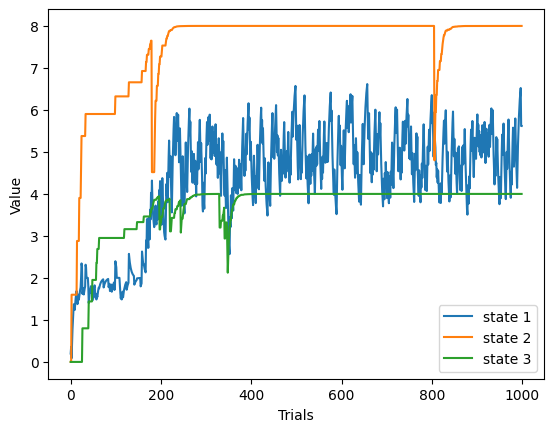

In [12]:
w,policy_hist_1,policy_hist_2,policy_hist_3,delta_hist=test_case()
plt.plot(w[1,:],label='state 1')
plt.plot(w[2,:],label='state 2')
plt.plot(w[3,:],label='state 3')
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Value')
plt.show()

In [13]:

def ensemble():
    num_states=3
    n_trials=1000
    alpha=0.075
    ensembe_size=1000
    beta=1

    alpha_A=0.075
    
    w_ensemble=np.zeros((num_states+1,n_trials,ensembe_size))
    policy_hist_1_ensemble=np.zeros((3,n_trials,ensembe_size))
    policy_hist_2_ensemble=np.zeros((2,n_trials,ensembe_size))
    policy_hist_3_ensemble=np.zeros((2,n_trials,ensembe_size))
    
    for i in range(ensembe_size):
        print(f'Ensemble step is {i}')
        w_ensemble[:,:,i],policy_hist_1_ensemble[:,:,i],policy_hist_2_ensemble[:,:,i],policy_hist_3_ensemble[:,:,i],delta_hist=actor_critic(n_trials,alpha,beta,alpha_A)

    w_ensemble_mean=np.mean(w_ensemble,axis=2)
    policy_hist_1_ensemble=np.mean(policy_hist_1_ensemble,axis=2)
    policy_hist_2_ensemble=np.mean(policy_hist_2_ensemble,axis=2)
    policy_hist_3_ensemble=np.mean(policy_hist_3_ensemble,axis=2)
    
    return w_ensemble_mean, policy_hist_1_ensemble,policy_hist_2_ensemble,policy_hist_3_ensemble,delta_hist




In [14]:
# Parameter initialization 
beta=1
alpha=0.2
alpha_A=0.075
n_trials=1000

w_ensemble_mean, policy_hist_1_ensemble,policy_hist_2_ensemble,policy_hist_3_ensemble,delta_hist=ensemble()



    

/var/folders/jq/bnhdr3191qx3y7b5tw2sztvr0000gn/T/ipykernel_53390/1628407170.py:12: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  total_sum=np.sum( np.exp(beta*m_i) for m_i in m )


Ensemble step is 0
Ensemble step is 1
Ensemble step is 2
Ensemble step is 3
Ensemble step is 4
Ensemble step is 5
Ensemble step is 6
Ensemble step is 7
Ensemble step is 8
Ensemble step is 9
Ensemble step is 10
Ensemble step is 11
Ensemble step is 12
Ensemble step is 13
Ensemble step is 14
Ensemble step is 15
Ensemble step is 16
Ensemble step is 17
Ensemble step is 18
Ensemble step is 19
Ensemble step is 20
Ensemble step is 21
Ensemble step is 22
Ensemble step is 23
Ensemble step is 24
Ensemble step is 25
Ensemble step is 26
Ensemble step is 27
Ensemble step is 28
Ensemble step is 29
Ensemble step is 30
Ensemble step is 31
Ensemble step is 32
Ensemble step is 33
Ensemble step is 34
Ensemble step is 35
Ensemble step is 36
Ensemble step is 37
Ensemble step is 38
Ensemble step is 39
Ensemble step is 40
Ensemble step is 41
Ensemble step is 42
Ensemble step is 43
Ensemble step is 44
Ensemble step is 45
Ensemble step is 46
Ensemble step is 47
Ensemble step is 48
Ensemble step is 49
Ensemble s

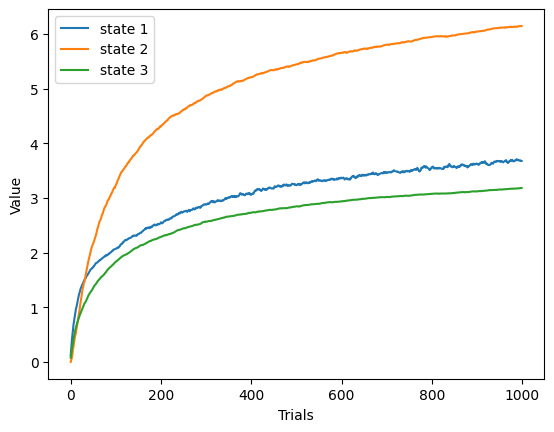

In [15]:

plt.plot(w_ensemble_mean[1,:],label='state 1')
plt.plot(w_ensemble_mean[2,:],label='state 2')
plt.plot(w_ensemble_mean[3,:],label='state 3')
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Value')
plt.show()

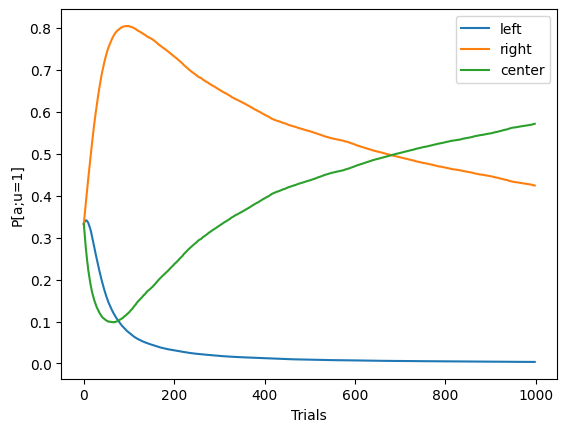

In [16]:
plt.figure() 

plt.plot(policy_hist_1_ensemble[0,:-1],label='left')
plt.plot(policy_hist_1_ensemble[1,:-1],label='right')
plt.plot(policy_hist_1_ensemble[2,:-1],label='center')
plt.xlabel('Trials')
plt.ylabel('P[a;u=1]')
plt.legend()


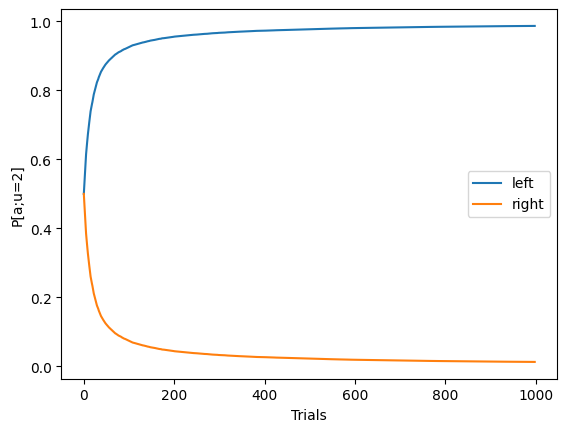

In [17]:
plt.plot(policy_hist_2_ensemble[0,:-1],label='left')
plt.plot(policy_hist_2_ensemble[1,:-1],label='right')
plt.xlabel('Trials')
plt.ylabel('P[a;u=2]')
plt.legend()

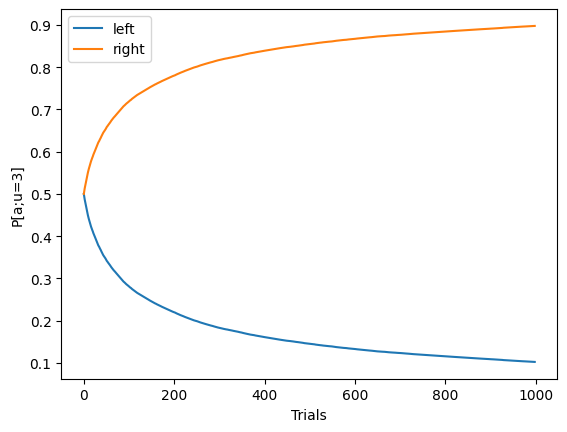

In [18]:
plt.plot(policy_hist_3_ensemble[0,:-1],label='left')
plt.plot(policy_hist_3_ensemble[1,:-1],label='right')
plt.xlabel('Trials')
plt.ylabel('P[a;u=3]')
plt.legend()

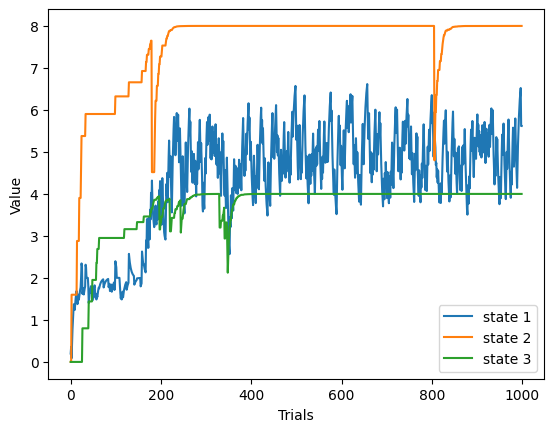

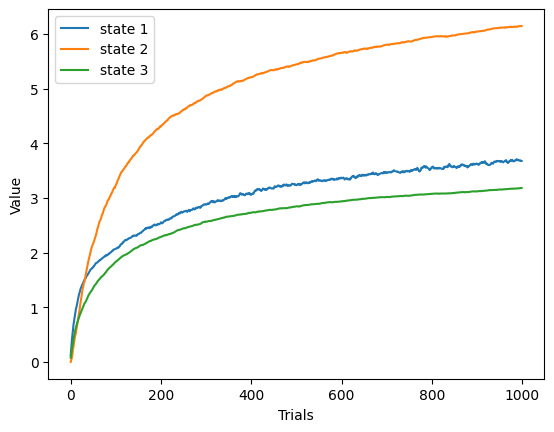

In [19]:

plt.plot(w[1,:],label='state 1')
plt.plot(w[2,:],label='state 2')
plt.plot(w[3,:],label='state 3')
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Value')
plt.show()






plt.plot(w_ensemble_mean[1,:],label='state 1')
plt.plot(w_ensemble_mean[2,:],label='state 2')
plt.plot(w_ensemble_mean[3,:],label='state 3')
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Value')
plt.show()

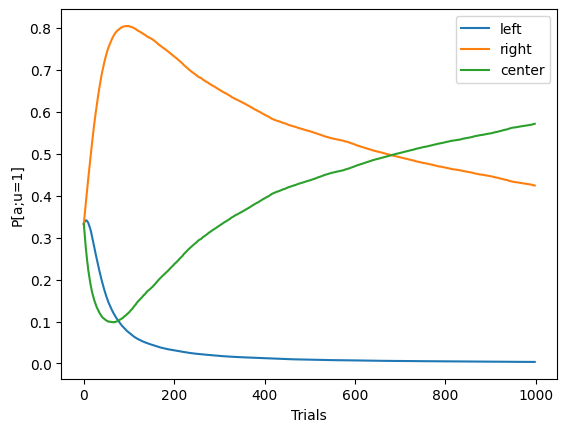

In [20]:
plt.figure() 

plt.plot(policy_hist_1_ensemble[0,:-1],label='left')
plt.plot(policy_hist_1_ensemble[1,:-1],label='right')
plt.plot(policy_hist_1_ensemble[2,:-1],label='center')
plt.xlabel('Trials')
plt.ylabel('P[a;u=1]')
plt.legend()


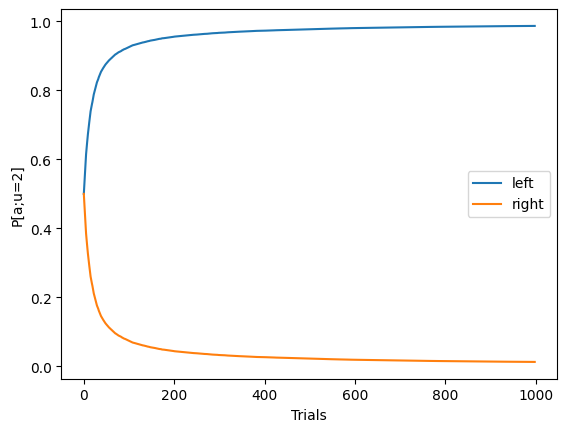

In [21]:
plt.plot(policy_hist_2_ensemble[0,:-1],label='left')
plt.plot(policy_hist_2_ensemble[1,:-1],label='right')
plt.xlabel('Trials')
plt.ylabel('P[a;u=2]')
plt.legend()

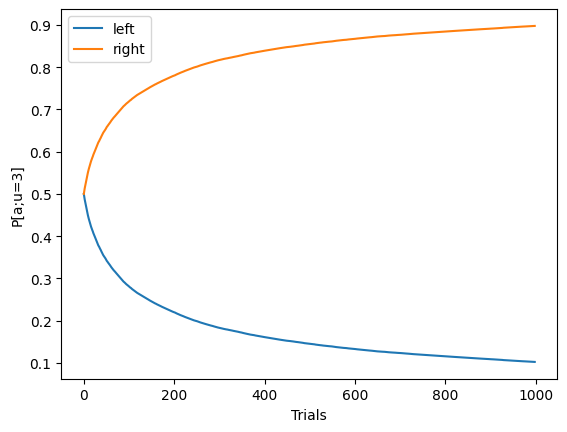

In [22]:
plt.plot(policy_hist_3_ensemble[0,:-1],label='left')
plt.plot(policy_hist_3_ensemble[1,:-1],label='right')
plt.xlabel('Trials')
plt.ylabel('P[a;u=3]')
plt.legend()

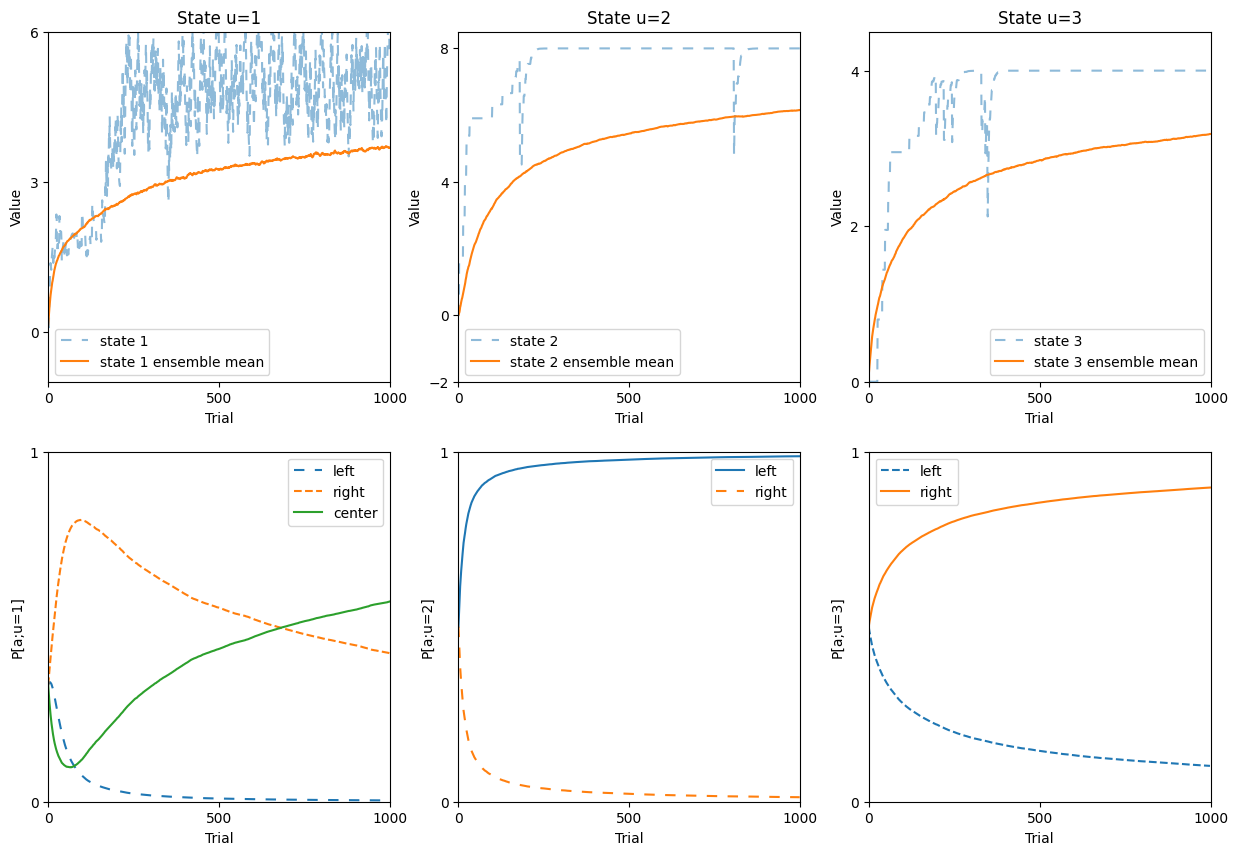

In [26]:
# in 2*6 subplots, in the first row, plot in the first,second, and third column the value function along with the ensemble mean for each state both functions in one subplot
# in the second row, plot the policy function for each state for both the ensemble mean and the single run in one subplot

ax,fig=plt.subplots(2,3,figsize=(15,10))

fig[0,0].plot(w[1,:],'-',label='state 1',alpha=0.5,dashes=(5, 5))
fig[0,0].plot(w_ensemble_mean[1,:],label='state 1 ensemble mean')
fig[0,0].legend()
fig[0,0].set_xlabel('Trial')
fig[0,0].set_ylabel('Value')
fig[0,0].set_ylim(-1,6)
fig[0,0].set_xlim(0,1000)
# Set ticks for 0,3,6 on y axis and 0,500,1000 on x axis
fig[0,0].set_xticks([0,500,1000])
fig[0,0].set_yticks([0,3,6])
# title subplot 
fig[0,0].set_title('State u=1')



fig[0,1].plot(w[2,:],'-',label='state 2',alpha=0.5,dashes=(5, 5))
fig[0,1].plot(w_ensemble_mean[2,:],label='state 2 ensemble mean')
fig[0,1].legend()
fig[0,1].set_xlabel('Trial')
fig[0,1].set_ylabel('Value')
fig[0,1].set_ylim(-2,8.5)
fig[0,1].set_xlim(0,1000)
# Set ticks for -2,0,4,8 on y axis and 0,500,1000 on x axis
fig[0,1].set_xticks([0,500,1000])
fig[0,1].set_yticks([-2,0,4,8])
fig[0,1].set_title('State u=2')

fig[0,2].plot(w[3,:],'-',label='state 3',alpha=0.5,dashes=(5, 5))
fig[0,2].plot(w_ensemble_mean[3,:],label='state 3 ensemble mean')
fig[0,2].legend()
fig[0,2].set_xlabel('Trial')
fig[0,2].set_ylabel('Value')
fig[0,2].set_ylim(0,4.5)
fig[0,2].set_xlim(0,1000)
# Set ticks for 0,2,4 on y axis and 0,500,1000 on x axis
fig[0,2].set_xticks([0,500,1000])
fig[0,2].set_yticks([0,2,4])
fig[0,2].set_title('State u=3')

fig[1,0].plot(policy_hist_1_ensemble[0,:-1],'--',label='left',dashes=(5, 5))
#make the right policy distant dots
fig[1,0].plot(policy_hist_1_ensemble[1,:-1],'--',label='right')
fig[1,0].plot(policy_hist_1_ensemble[2,:-1],'-',label='center')
fig[1,0].legend()
# Set ticks for 0,1 on y axis and 0,500,1000 on x axis
fig[1,0].set_xticks([0,500,1000])
fig[1,0].set_yticks([0,1])
fig[1,0].set_xlabel('Trial')
fig[1,0].set_ylabel('P[a;u=1]')
fig[1,0].set_xlim(0,1000)
fig[1,0].set_ylim(0,1)


fig[1,1].plot(policy_hist_2_ensemble[0,:-1],'-',label='left')
fig[1,1].plot(policy_hist_2_ensemble[1,:-1],'--',label='right',dashes=(5, 5))
fig[1,1].legend()
fig[1,1].set_xticks([0,500,1000])
fig[1,1].set_yticks([0,1])
fig[1,1].set_xlabel('Trial')
fig[1,1].set_ylabel('P[a;u=2]')
fig[1,1].set_xlim(0,1000)
fig[1,1].set_ylim(0,1)


fig[1,2].plot(policy_hist_3_ensemble[0,:-1],'--',label='left')
fig[1,2].plot(policy_hist_3_ensemble[1,:-1],'-',label='right')
fig[1,2].legend()
fig[1,2].set_xticks([0,500,1000])
fig[1,2].set_yticks([0,1])
fig[1,2].set_xlabel('Trial')
fig[1,2].set_ylabel('P[a;u=3]')
fig[1,2].set_xlim(0,1000)
fig[1,2].set_ylim(0,1)


# save the figure
plt.savefig('actor_critic_ensemble_mean.png',dpi=300)


